In [3]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Обработка текста
import re
from collections import Counter, defaultdict
import string

# NLP библиотеки
try:
    import spacy
    nlp = spacy.load('ru_core_news_sm')
    SPACY_AVAILABLE = True
except:
    SPACY_AVAILABLE = False
    print("⚠️ Русская модель SpaCy недоступна. Некоторые NLP функции будут ограничены.")

# Библиотеки для сходства и машинного обучения
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Нечеткое сопоставление
from rapidfuzz import fuzz, process
from fuzzywuzzy import fuzz as fuzz_wuzzy

# Визуализация
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Импорты проекта SAMe
import sys
sys.path.append('../../src')

try:
    from same_api.data_manager import data_helper
    from same_clear.text_processing.text_cleaner import TextCleaner, CleaningConfig
    from same_clear.text_processing.lemmatizer import Lemmatizer, LemmatizerConfig
    from same_clear.text_processing.normalizer import TextNormalizer, NormalizerConfig
    SAME_MODULES_AVAILABLE = True
    print("✅ Модули SAMe успешно загружены")
except ImportError as e:
    SAME_MODULES_AVAILABLE = False
    print(f"⚠️ Модули SAMe недоступны: {e}")

# Конфигурация
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("🚀 Настройка завершена успешно!")

✅ Модули SAMe успешно загружены
🚀 Настройка завершена успешно!


In [4]:
# df = pd.read_csv(data_helper["data"] / "output/full_3_advanced.csv")
df = pd.read_csv("catalog_with_clusters.csv")
df_dubl = pd.read_csv(data_helper["data"] / "output/catalog_with_dbscan_clusters.csv")
df["Cluster_ID_DBSCAN"] = df_dubl["Cluster_ID_DBSCAN"]
print(len(df))

130303


In [26]:
# === Очистка и нормализация текста ===
def normalize(text):
    # text = str(text).lower()
    delete = [")", "(", ":", ";", "!", "?", "№", "#", "%", "/",
              ".", ",", "-", "для", "гост", "ГОСТ"]
    
    for d in delete:
        text = text.replace(d, "")
    
    text = re.sub(r'<[^>]*>', '', text)

    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    text = text.replace("color", "").replace("num", "")

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join(filter(lambda x: not any([c.isdigit() for c in x]), text.split()))
    text = " ".join(filter(lambda x: len(x) > 2, text.split()))
    
    return text

In [27]:
df['Normalized'] = df['Normalized_Name'].apply(normalize)

In [7]:
def adaptive_threshold(name1, name2):
    avg_len = (len(name1) + len(name2)) / 2
    if avg_len < 30:
        return 85  
    elif avg_len < 60:
        return 70
    else:
        return 50

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=2)
X = vectorizer.fit_transform(df['Normalized']) 

In [29]:
# Суммируем TF-IDF значения по всем документам (ось 0)
tfidf_sums = np.asarray(X.sum(axis=0)).ravel()

# Сопоставим n-граммы и их суммарный TF-IDF
terms = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'ngram': terms, 'tfidf': tfidf_sums})

# Сортируем по значимости
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

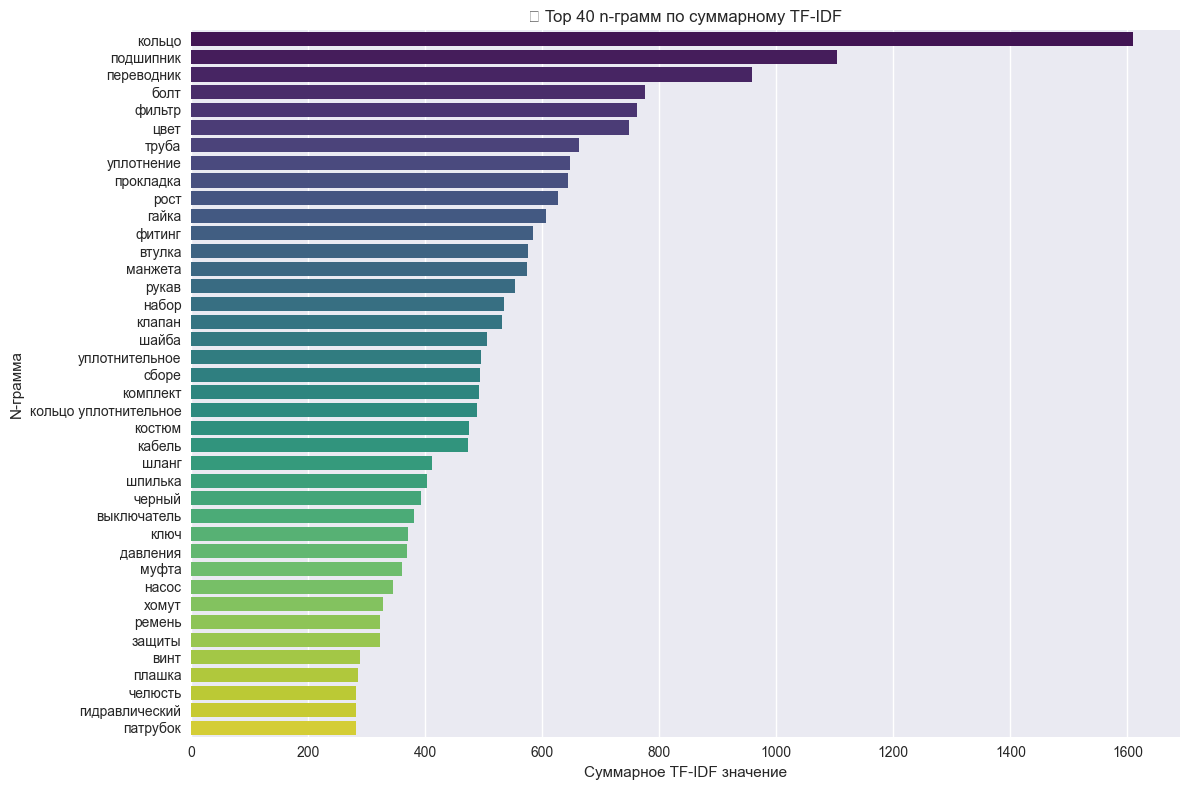

In [33]:
import seaborn as sns

plt.figure(figsize=(12, 8))
top_n = 40
sns.barplot(data=tfidf_df.head(top_n), x='tfidf', y='ngram', palette='viridis')
plt.title(f'🔝 Top {top_n} n-грамм по суммарному TF-IDF')
plt.xlabel('Суммарное TF-IDF значение')
plt.ylabel('N-грамма')
plt.tight_layout()
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
from rapidfuzz.fuzz import ratio

# === Sentence-BERT модель ===
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(df["Normalized"].tolist(), convert_to_tensor=False)

In [35]:
# === Кластеризация DBSCAN по косинусной дистанции ===
clustering = DBSCAN(eps=0.3, min_samples=2, metric="cosine")
df["Cluster_DBSCAN"] = clustering.fit_predict(embeddings)

In [ ]:

# === Анализ кластеров ===
results = []

for cluster_id in sorted(df["Cluster_DBSCAN"].unique()):
    if cluster_id == -1:
        continue  

    cluster_df = df[df["Cluster_DBSCAN"] == cluster_id].copy()
    names = cluster_df["Normalized"].tolist()

    # Эталон — самая короткая строка
    reference = min(names, key=len)

    for name in names:
        similarity = ratio(reference, name)
        results.append({
            "Cluster": cluster_id,
            "Reference": reference,
            "Name": name,
            "Similarity": similarity
        })

# === Вывод результатов ===
result_df = pd.DataFrame(results)
print(result_df.sort_values(["Cluster", "Similarity"], ascending=[True, False]))

        Cluster             Reference                  Name  Similarity
18999         0                                                   100.0
58765         0                                                   100.0
68384         0                                                   100.0
73513         0                                                   100.0
100027        0                                                   100.0
...         ...                   ...                   ...         ...
129069      251  Хомут усиленный Vers  Хомут усиленный Vers       100.0
129070      251  Хомут усиленный Vers  Хомут усиленный Vers       100.0
129071      251  Хомут усиленный Vers  Хомут усиленный Vers       100.0
129072      251  Хомут усиленный Vers  Хомут усиленный Vers       100.0
129073      251  Хомут усиленный Vers  Хомут усиленный Vers       100.0

[129074 rows x 4 columns]


In [60]:
df.groupby("Cluster_DBSCAN").agg({"Raw_Name": "count"}).sort_values("Raw_Name", ascending=False)

,Raw_Name
Cluster_DBSCAN,
0,128337
-1,1229
91,19
39,18
148,18
...,...
49,2
134,2
135,2


In [61]:
len(df)

130303

In [75]:
result_df = {
    "Код": [],
    "Наименование": [],
    "Дубликат": [],
    "Схожесть": [],
    "Кластер": [],
    "Комментарий": []
}

In [76]:
def clear_row(df):
    global result_df
    for i, row in df.iterrows():
        if not row["Normalized"]:
            result_df["Код"].append(row["Код"])
            result_df["Наименование"].append(row["Raw_Name"])
            result_df["Дубликат"].append([])
            result_df["Схожесть"].append(0)
            result_df["Комментарий"].append("Пустое наименование после обработки")
            result_df["Кластер"].append(-1)


In [ ]:
clear_row(df)

In [81]:
for x in result_df["Код"]:
    df.drop(df[df["Код"] == x].index, inplace=True)

In [ ]:
df.groupby("Cluster_DBSCAN")

In [97]:
cluster_df1 = df[df["Cluster_DBSCAN"] == 0]
cluster_df2 = df[df["Cluster_DBSCAN"] == -1]
cluster_df1["vector_word"] = cluster_df1["Normalized"].apply(lambda x: x.split())
cluster_df1["firt_word"] = cluster_df1["Normalized"].apply(lambda x: x.split()[0])
cluster_df2["firt_word"] = cluster_df2["Normalized"].apply(lambda x: x.split()[0])
cluster_df2["vector_word"] = cluster_df2["Normalized"].apply(lambda x: x.split())

In [104]:
cluster_group = {}
for i, group in cluster_df1.groupby("firt_word"):
    cluster_group.setdefault(i, [])
    cluster_group[i].extend(group["Код"])

for i, group in cluster_df2.groupby("firt_word"):
    cluster_group.setdefault(i, [])
    cluster_group[i].extend(group["Код"])

In [103]:
cluster_group

{'Abac': ['ХС-000000405'],
 'Baramine': ['МС-016603'],
 'CRM': ['Ц0000078066'],
 'CemFrost': ['ЦЦС000011458', 'ЦЦС000011460'],
 'Circlip': ['НИ-IS0014588'],
 'Cветильник': ['НИ-IS0032430',
  'НИ-IS0040225',
  'НИ-IS0045675',
  'НИ-IS0046210'],
 'Cплитсистема': ['НИ-IS0047993'],
 'Cпрей': ['НИ-IS0047648', 'НИ-IS0047649'],
 'Cредство': ['НИ-IS0047659'],
 'Cтиральный': ['НИ-IS0023737'],
 'Cтол': ['НИ-000021008'],
 'Cтроп': ['НИ-IS0047372'],
 'Cумка': ['НИ-000028728'],
 'Cухой': ['НИ-000043138'],
 'Cъемник': ['НИ-IS0050064'],
 'DBXL': ['НИ-IS0041504'],
 'DINрейка': ['Ц0000094841',
  'Ц0000094997',
  'Ц00000038691',
  'Ц0000032863',
  'Ц0000032862',
  'Ц0000024225',
  'Ц0000054830',
  'Ц0000126102'],
 'ELEMENT': ['Ц00000006741'],
 'ELEMENTSUCTION': ['Ц00000006740'],
 'ERP': ['Ц0000078051'],
 'EasyHEC': ['НИ-IS0038457'],
 'FOAM': ['ЦЦС000008788'],
 'Floss': ['НИ-IS0045539'],
 'IPкамера': ['Ц0000046231', 'Ц0000069552', 'Ц0000056022', 'Ц0000069554'],
 'ITIL': ['Ц0000078052'],
 'Kольцо': ['НИ-I

In [117]:
clusters = df[df["Cluster_DBSCAN"] != 0]
clusters = clusters[clusters["Cluster_DBSCAN"] != -1]
len(clusters)

737

In [134]:
# print(*cluster_group.keys(), sep="\n")
clusters["vector_word"] = clusters["Normalized"].apply(lambda x: list(map(lambda x: x.lower(), x.split())))

In [ ]:
def cluster_force(cluster: list[str]) -> dict:
    cluster_result = {}
    for row in cluster["vector_word"]:
        pass

In [167]:
clusster_buffer = {}
duble = {}
for word, code in cluster_group.items():
    word = word.lower()
    
    cluster_world = clusters[clusters["vector_word"].apply(lambda x: word in x)]

    if len(cluster_world) == 0:
           continue
    
    # print(word)
    # print(cluster_world["Normalized"])
    # print(cluster_world["Cluster_DBSCAN"])
    # print("-" * 100)

    for cod in code:
        df_code = df[df["Код"] == cod]
        name = df_code["Normalized"].values[0]
        duble.setdefault(name, [])
        duble[name].append(df_code["Код"])
        # clusster_buffer.setdefault(len(clusster_buffer)+1, [])
        # clusster_buffer[len(clusster_buffer)].append(cod)
        # if len(cluster_world["Cluster_DBSCAN"].unique()) == 1:
        #     clusster_buffer[len(clusster_buffer)].extend(cluster_world["Код"].tolist())
        # else:
        #     # print(word)
        #     name = df[df["Код"] == cod]["Normalized"].values[0]
        #     duble.setdefault(name, [])
        #     duble[name].extend(df[df["Код"] == cod]["Код"])
            # print(name)
            # print(cluster_world["Normalized"])
            # print(cluster_world["Cluster_DBSCAN"])
            # cluster_perbor(cluster_world)
            # print("-" * 100)

duble = {key: value for key, value in duble.items() if len(value) > 1}


In [169]:
for key, value in duble.items():
    print(key)
    print(value)
    print("-" * 100)

Plus Аппарат высок давл серийный номер
[86677    МС-019939
Name: Код, dtype: object, 86678    МС-019938
Name: Код, dtype: object, 86679    ЦЦС00106302
Name: Код, dtype: object]
----------------------------------------------------------------------------------------------------
Автомобиль Садко Next
[14706    НИ-IS0040153
Name: Код, dtype: object, 14707    НИ-IS0040154
Name: Код, dtype: object, 14708    НИ-IS0040155
Name: Код, dtype: object, 14709    НИ-IS0040156
Name: Код, dtype: object, 14710    НИ-IS0034652
Name: Код, dtype: object]
----------------------------------------------------------------------------------------------------
Адаптер
[14811    Ц0000124303
Name: Код, dtype: object, 22918    НИ-000020592
Name: Код, dtype: object, 22920    НИ-IS0043945
Name: Код, dtype: object, 31312    НИ-000015023
Name: Код, dtype: object, 31313    Ц00000006674
Name: Код, dtype: object, 31314    МСКН0017012
Name: Код, dtype: object, 31315    НИ-000004379
Name: Код, dtype: object, 31316    НИ-000

In [155]:
clusster_buffer

{1: ['НИ-000017414', 'НИ-IS0007680', 'НИ-IS0007681'],
 2: ['НИ-IS0040153', 'НИ-IS0007680', 'НИ-IS0007681'],
 3: ['НИ-IS0040154', 'НИ-IS0007680', 'НИ-IS0007681'],
 4: ['НИ-IS0040155', 'НИ-IS0007680', 'НИ-IS0007681'],
 5: ['НИ-IS0040156', 'НИ-IS0007680', 'НИ-IS0007681'],
 6: ['НИ-IS0034652', 'НИ-IS0007680', 'НИ-IS0007681'],
 7: ['НИ-000010795', 'НИ-IS0007680', 'НИ-IS0007681'],
 8: ['НИ-IS0043025'],
 9: ['НИ-IS0046151', 'НИ-000039175'],
 10: ['НИ-IS0026360', 'НИ-000039175'],
 11: ['НИ-IS0050030', 'НИ-000039175'],
 12: ['НИ-IS0023396', 'НИ-000039175'],
 13: ['НИ-IS0049191', 'НИ-000039175'],
 14: ['НИ-IS0052647', 'НИ-000039175'],
 15: ['НИ-IS0048398', 'НИ-000039175'],
 16: ['НИ-IS0052190', 'НИ-000039175'],
 17: ['НИ-IS0017012', 'НИ-000039175'],
 18: ['НИ-IS0044207', 'НИ-000039175'],
 19: ['НИ-IS0041815', 'НИ-000039175'],
 20: ['НИ-IS0045204', 'НИ-000039175'],
 21: ['НИ-IS0037212', 'НИ-000039175'],
 22: ['НИ-IS0020411', 'НИ-000039175'],
 23: ['НИ-IS0032678', 'НИ-000039175'],
 24: ['НИ-IS0021

In [ ]:
for i, row in clusters.iterrows():
    

1
Бита NOX STRONG
1
Бита ударная NOX
2
Блок питания PCP
3
Бур Rennbohr Basic Optim
3
Бур Rennbohr Basic Optim
4
Валик малярный сборе микроволокно KORVUS
4
Валик малярный сборе микроволокно KORVUS
5
Видеокарта ASUS NVIDIA GeForce SILENT
6
Герметик системы охлаждения Felix
7
Головка торцевая универсальная Best Room
8
Губка образивная Norton
9
Карта памяти AData Canvas React
9
Карта памяти Canvas Select Plus
10
КартаSIM Iridium
11
Ключ цепной Brexit дюйма
12
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER XXXL
12
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER
12
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER XXXL
12
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER XXXL
13
Комплект уплотнений распределителя Seal kit for
14
Конфеты Ferrero Rocher
15
Конфеты Raffaello
15
Конфеты Raffaello
16
Коран
16
Коран

In [ ]:
len(cluster_group)

5198

In [118]:
sum([len(i) for i in cluster_group.values()])

129541

In [122]:
len(result_df["Код"])

19

In [120]:
130303 - 129541 + 737

1499

In [67]:
for i, row in df.iterrows():
    # if "бензин" in row["Normalized"].lower():
    #     print(row["Normalized"])
    #     print(row["Cluster_DBSCAN"])    
    if row["Cluster_DBSCAN"] == -1:
        print(row["Normalized"])

Cистема IPDECT Yealink контроллер микросота DECT
Dallas Lock СЗИ НСД СКН
Адаптер WiF компьютера AlisaFox адаптеры Мбит черный
Адаптер установочного устройства Kit Adapter Baker Setting Tool CPF
Антенна PETRA Broad Bend MIMO
Аппарат точечной сварки ручной портативный педалью EGP Wark
Бананычипсы Семушка
Батончик Chikalab глазированный протеином Тирамису
Бафф летний спортивный материал олипм плотность слойный
Блок дозировочный ISBe
Болгарка электрическая bosch GWS мин
Болт фитинг банджо
Бумага лSvetocopy
Ваучер электронный минут сроком действия один год
Ваучер электронный Россия минут сроком дейстия год
Вафли Natures own factory
Ведро мусорное IQBIO HOME
Веник плетеной ручкой автомобильный Молдова
Вентилятор Smartmi Pedestal Fan белый Втскоростейпульт
Весы лабораторные MER ACF LCD Accurate
Весы цифровые крановые водонепроницаемые фунтов
Видеокарта игровая AMD Rаdеоn ver
Вилка белая UPS
Вино Паддл Крик Совиньон Блан Мальборо Новая Зеландия молодое белое полусухое
Винт LOW PROFILE SHC
болт

In [ ]:
def distribution_cluster(cluster_df):
    pass

In [ ]:
def creat_tokens_vector(name):
    

In [56]:
result_df.head()

,Cluster,Reference,Name,Similarity
0,0,,Cветильник LED панель ДПО Призма Neox,0.0
1,0,,Cветильник потолочныйOsairousБелый LED Светоди...,0.0
2,0,,Cпрей ванной комнаты Sanfor Санфор,0.0
3,0,,Cпрей ультрабелый Sanfor Санфор,0.0
4,0,,Cредство чистящее Биолан Сочное яблоко Нэфис,0.0


In [ ]:
cluster_counts = result_df.groupby("Cluster").size()

sorted_clusters = cluster_counts.sort_values(ascending=False)

cluster_list = sorted_clusters.index.tolist()

df_cluster = df[df["Cluster_DBSCAN"] == cluster_list[0]]


[0, 91, 39, 148, 194, 140, 251, 133, 94, 5, 74, 172, 239, 165, 141, 68, 59, 1, 235, 95, 193, 80, 166, 128, 122, 158, 93, 40, 36, 47, 219, 34, 110, 76, 51, 153, 26, 83, 163, 21, 142, 162, 53, 160, 12, 97, 2, 85, 78, 155, 84, 202, 7, 192, 8, 157, 150, 159, 147, 145, 164, 169, 125, 101, 116, 114, 182, 112, 183, 188, 191, 179, 154, 27, 16, 44, 45, 233, 35, 31, 23, 41, 14, 10, 247, 176, 173, 249, 234, 174, 175, 177, 248, 178, 232, 156, 250, 180, 236, 237, 246, 171, 170, 238, 181, 168, 167, 240, 241, 242, 243, 244, 245, 161, 207, 231, 208, 214, 197, 198, 199, 200, 201, 216, 215, 213, 196, 212, 211, 204, 210, 205, 209, 206, 217, 218, 230, 190, 229, 184, 185, 186, 187, 228, 189, 227, 220, 226, 225, 224, 223, 222, 195, 221, 203, 129, 152, 151, 50, 52, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 75, 49, 48, 46, 24, 9, 11, 13, 15, 17, 18, 19, 20, 22, 25, 43, 28, 29, 30, 32, 33, 37, 38, 6, 42, 77, 79, 81, 135, 120, 121, 123, 124, 127, 130, 131, 132, 134, 136, 118, 137, 

In [42]:
last_id = None
for i, row in result_df.iterrows():
    if row["Similarity"] < 90:
        continue
    if not row["Name"]:
        continue

    if last_id is None or row["Cluster"] != last_id:
        print("=" * 80)
        print(f"\nКластер {row['Cluster']}")
        last_id = row["Cluster"]
    print(row["Name"])


Кластер 1
Набор бит NOX

Кластер 2
Блок питания PCP

Кластер 3
Бур Rennbohr Basic Optim
Бур Rennbohr Basic Optim

Кластер 4
Валик малярный сборе микроволокно KORVUS
Валик малярный сборе микроволокно KORVUS

Кластер 5
Видеокарта Asus PCIE GeForce

Кластер 6
Герметик системы охлаждения Felix

Кластер 7
Струбцина угловая Best Room

Кластер 8
Диск отрезной Norton

Кластер 9
Карта памяти AData Canvas React

Кластер 10
КартаSIM Iridium

Кластер 11
Ключ ременной Brexit

Кластер 12
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER XXXL
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER XXXL
Комбинезон специальный защитный ограниченного срока использования модель торговой марки KONZER XXXL

Кластер 13
Комплект уплотнений TDS Kit Seal TDS

Кластер 14
Конфеты Ferrero Rocher

Кластер 15
Конфеты Raffaello
Конфеты Raf